In [1]:
import json
from collections import Counter, defaultdict
import gc

import numpy as np
import pandas as pd
import glob
import time
from tqdm import tqdm

from sklearn import model_selection, metrics
import matplotlib.pyplot as plt
import seaborn as sn

import lightgbm as lgb


#import riiideducation

In [2]:
import feather

In [5]:
question = pd.read_csv("/home/pocket/input/questions.csv")
question.head(2)

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81


<AxesSubplot:>

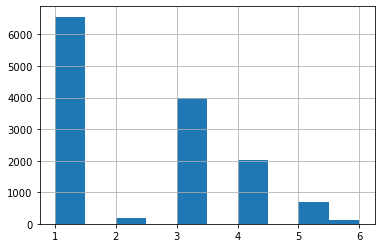

In [6]:
question["tags"].astype(str).apply(lambda x: len(x.split())).hist()

In [22]:
train = pd.read_feather("./train_sorted.feather")

In [23]:
print(train.columns)

# no lectures for now
train = train[train["answered_correctly"] != -1]

Index(['row_id', 'timestamp', 'user_id', 'content_id', 'content_type_id',
       'task_container_id', 'user_answer', 'answered_correctly',
       'prior_question_elapsed_time', 'prior_question_had_explanation',
       'max_time_stamp', 'rand_time_stamp', 'virtual_time_stamp'],
      dtype='object')


In [24]:
u_cnt = Counter()
u_ac_cnt = Counter()
u_prev_ts = {}
uc_prev_ts = {}
u_prev_ac = {}
uc_prev_ac = {}
u_prev_ua = {}
u_prev_qm = {}
u_ac_sum, u_qm_sum = Counter(), Counter()

def init_values():
    #u_cnt.clear()
    #u_ac_cnt.clear()
    u_prev_ts.clear()
    #uc_prev_ts.clear()
    u_prev_ac.clear()
    #uc_prev_ac.clear()
    u_prev_ua.clear()
    u_prev_qm.clear()
    #u_ac_sum.clear()
    #u_qm_sum.clear()

def update_ac_values(prev_rows, prev_acs, prev_uas):
    #for i, row in enumerate(prev_df.values):
    for i, row in enumerate(prev_rows):
        update_ac_value(row, prev_acs[i], prev_uas[i])
    
def update_ac_value(row, prev_ac, prev_ua):
    uid = row[2]
    cid = row[3]
    ucid = (uid, cid)
    
    u_ac_cnt[uid] += 1
    u_ac_sum[uid] += prev_ac
    u_prev_ac[uid] = prev_ac
    uc_prev_ac[ucid] = prev_ac
    u_prev_ua[uid] = prev_ua

def make_row(row, data_list, is_train=True):
    ts = row[1]
    uid = row[2]
    cid = row[3]
    tcid = row[5]
    if is_train:
        et = row[8]
        pqhe = row[9]
    else:
        et = row[6]
        pqhe = row[7]
    ucid = (uid, cid)
    utcid = (uid, tcid)
    contents = contents_dict[cid]
    
    output = {}
    if is_train:
        output["ac"] = row[7]
    output["ts"] = ts
    output["uid"] = uid
    output["cid"] = cid
    output["tcid"] = tcid
    output["et"] = et
    output["pqhe"] = pqhe
    content_col = [
        "q_ac_mean", "q_ac_cnt", "q_et_mean", "q_et_cnt", "q_et_std", "b_ac_mean", "b_ac_cnt",
    ]
    for c in content_col:
        output[c] = contents[c]
    
    output["u_td"] = u_prev_ts.get(uid, np.nan) - ts
    output["uc_td"] = uc_prev_ts.get(ucid, np.nan) - ts
    u_prev_ts[uid] = ts
    uc_prev_ts[ucid] = ts
    
    output["u_prev_ac"] = u_prev_ac.get(uid, np.nan)
    output["uc_prev_ac"] = uc_prev_ac.get(ucid, np.nan)
    output["u_prev_qm"] = u_prev_qm.get(uid, np.nan)
    output["u_prev_ua"] = u_prev_ua.get(uid, np.nan)
    u_prev_qm[uid] = contents["q_ac_mean"]
    
    u_cnt[uid] += 1
    u_qm_sum[uid] += contents["q_ac_mean"]
    output["u_cnt"] = u_cnt[uid]
    output["u_ac_cnt"] = u_ac_cnt[uid]
    output["u_ac_mean"] = (u_ac_sum[uid] / u_ac_cnt[uid]) if u_ac_cnt[uid] != 0 else np.nan
    output["u_qm_mean"] = u_qm_sum[uid] / u_cnt[uid]
    
    data_list.append(output)
    return data_list


In [14]:
# content_train = train[:50*1000*1000].copy()
# train = train[50*1000*1000:]


# q_col = ["question_id", "bundle_id"]
# content_train = pd.merge(
#     content_train, question[q_col], left_on="content_id", right_on="question_id", how="left"
# )

# # contents features
# # there are no new contents in the test, so we use part of the train as the pseudo-training set
# temp = content_train.groupby("content_id")["answered_correctly"].agg(["mean", "count"])
# temp.columns = ["q_ac_mean", "q_ac_cnt"]
# temp2 = content_train.groupby("content_id")["prior_question_elapsed_time"].agg(["mean", "count", "std"])
# temp2.columns = ["q_et_mean", "q_et_cnt", "q_et_std"]
# # temp3 = content_train.groupby("content_id")["timestamp_diff"].agg(["mean", "std", "min", "max", "skew"])
# # temp3.columns = ["q_td_mean", "q_td_std", "q_td_min", "q_td_max", "q_td_skew"]
# temp4 = content_train.groupby("bundle_id")["answered_correctly"].agg(["mean", "count"])
# temp4.columns = ["b_ac_mean", "b_ac_cnt"]
# q_col = ["question_id", "bundle_id", "part"]
# #q_col += [str(i) for i in range(188)]
# contents = pd.merge(question[q_col], temp, left_on="question_id", right_on="content_id", how="left")
# contents = pd.merge(contents, temp2, left_on="question_id", right_on="content_id", how="left")
# #contents = pd.merge(contents, temp3, left_on="question_id", right_on="content_id", how="left")
# contents = pd.merge(contents, temp4, on="bundle_id", how="left")
# print(contents.head(2))
# print(contents.shape)
# merge_col = [
#     "question_id", "q_ac_mean", "q_ac_cnt", "q_et_mean",
#     "q_et_cnt", "q_et_std", "b_ac_mean", "b_ac_cnt"
# ]
# contents = contents[merge_col]
# contents = contents.set_index("question_id")
# contents_dict = contents.to_dict("index")
# print(len(contents_dict))

   question_id  bundle_id  q_ac_mean  q_ac_cnt     q_et_mean  q_et_cnt  \
0            0          0   0.904942    3703.0  21888.376953    3702.0   
1            1          1   0.889641    3987.0  21801.617188    3987.0   

       q_et_std  b_ac_mean  b_ac_cnt  
0  11530.265963   0.904942    3703.0  
1  10502.874817   0.889641    3987.0  
(13523, 9)
13523


In [19]:
# with open("./contents_dict.pkl", "wb") as handle:
#     pickle.dump(contents_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
# print(len(contents_dict))

13523


In [20]:
import pickle
with open("./contents_dict.pkl", "rb") as handle:
    contents_dict = pickle.load(handle)
print(len(contents_dict))

13523


In [25]:
#content_train = train[:50*1000*1000].copy()
train = train[50*1000*1000:]

In [26]:
print(len(train))

49271300


In [29]:
class SingleLgb:
    def __init__(self, seed=99, dry_run=False):
        self.train_param = self.get_param()
        if dry_run:
            self.num_rounds = 100
        else:
            self.num_rounds = 1000

    def do_train_direct(self, x_train, x_test, y_train, y_test):
        lgb_train = lgb.Dataset(x_train, y_train)
        lgb_eval = lgb.Dataset(x_test, y_test)

        # print('Start training...')
        model = lgb.train(self.train_param,
                          lgb_train,
                          valid_sets=[lgb_eval],
                          verbose_eval=100,
                          num_boost_round=self.num_rounds,
                          early_stopping_rounds=100,
                          #categorical_feature=[]
                         )
        # print('End training...')
        return model

    @staticmethod
    def show_feature_importance(model, filename=None):
        fi = pd.DataFrame({
            "name": model.feature_name(),
            "importance_split": model.feature_importance(importance_type="split").astype(int),
            "importance_gain": model.feature_importance(importance_type="gain").astype(int),
        })
        fi = fi.sort_values(by="importance_gain", ascending=False)
        print(fi)
        #with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
            #print(df)

    @staticmethod
    def get_param():
        return {
            'num_leaves': 31,
            'min_data_in_leaf': 50,
            'objective': 'binary',
            'metric': 'auc',
            #'metric': 'binary_logloss',
            'max_depth': -1,
            'learning_rate': 0.05,
            "boosting": "gbdt",
            "feature_fraction": 0.9,
            "verbosity": -1,
            "random_state": 81,
        }
    
class SingleTrainer:
    def __init__(self, pred_col, dry_run=False):
        self.pred_col = pred_col
        self.target_col = "ac"
        self.dry_run = dry_run
        self.val_size = 4*1000*1000

    def train_model(self, df):
        X = df[self.pred_col]
        y = df[self.target_col]
        
        models, scores = list(), list()
        for fold in range(4):
            print("---------")
            print("fold=", fold)
            f, c = fold, self.val_size
            val_s, val_e = -c-f*c, len(df)-f*c
            train_idx = -c-f*c
            X_train, X_val = X.iloc[:train_idx], X.iloc[val_s:val_e]
            y_train, y_val = y.iloc[:train_idx], y.iloc[val_s:val_e]
            print(X_train.shape, X_val.shape)
            
            lgbm = SingleLgb(seed=99, dry_run=self.dry_run)
            model = lgbm.do_train_direct(X_train, X_val, y_train, y_val)
            score = model.best_score["valid_0"]["auc"]
            pred = model.predict(X_val)
            if fold == 0:
                lgbm.show_feature_importance(model)
            models.append(model)
            scores.append(score)
            break
        return models, np.mean(scores)

In [28]:
train_data_list = list()
utcid_set = set()
prev_rows, prev_acs, prev_uas = list(), list(), list()
init_values()

not_updated_idx = 0
for i, row in enumerate(tqdm(train.values)):
    uid = row[2]
    tcid = row[5]
    utcid = (uid, tcid)
    if utcid not in utcid_set:
        if len(prev_rows) > 0:
            #prev_df2 = train.iloc[not_updated_idx:i] iloc too slow lol
            update_ac_values(prev_rows, prev_acs, prev_uas)
            prev_rows.clear()
            prev_acs.clear()
            prev_uas.clear()
            utcid_set.clear()
            not_updated_idx = i
    prev_rows.append(row)
    prev_acs.append(row[7])
    prev_uas.append(row[6])
    utcid_set.add(utcid)
    if i % 3*1000*1000 == 0:
        init_values()
        
    make_row(row, train_data_list, True)
        
    
df = pd.DataFrame(train_data_list)
print(df.head(2))
#print(df.info())

100%|██████████| 49271300/49271300 [12:19<00:00, 66607.30it/s] 


   ac           ts         uid   cid  tcid       et  pqhe  q_ac_mean  \
0   1  23758731186   392484238  5499  1995  20000.0  True   0.817723   
1   1   1294359506  2041505565  8715   626  50000.0  True   0.669728   

   q_ac_cnt     q_et_mean  ...  u_td  uc_td  u_prev_ac  uc_prev_ac  u_prev_qm  \
0    1388.0  25007.816406  ...   NaN    NaN        NaN         NaN        NaN   
1    2831.0  25048.060547  ...   NaN    NaN        NaN         NaN        NaN   

   u_prev_ua  u_cnt  u_ac_cnt  u_ac_mean  u_qm_mean  
0        NaN      1         0        NaN   0.817723  
1        NaN      1         0        NaN   0.669728  

[2 rows x 24 columns]


In [30]:
print("hi")

hi


In [31]:
# %%timeit
# df = pd.DataFrame(data_list)
# 24.7 s ± 205 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

In [21]:
df.columns

Index(['ac', 'ts', 'uid', 'cid', 'tcid', 'et', 'pqhe', 'q_ac_mean', 'q_ac_cnt',
       'q_et_mean', 'q_et_cnt', 'q_et_std', 'b_ac_mean', 'b_ac_cnt', 'u_td',
       'uc_td', 'u_prev_ac', 'uc_prev_ac', 'u_prev_qm', 'u_prev_ua', 'u_cnt',
       'u_ac_cnt', 'u_ac_mean', 'u_qm_mean'],
      dtype='object')

In [36]:
pred_col = ['ts',  'q_ac_mean', 'q_ac_cnt',
    'q_et_mean', 'q_et_cnt', 'q_et_std', 'b_ac_mean', 'b_ac_cnt', 'u_td',
       'uc_td','u_prev_qm', 'u_cnt',
       'u_qm_mean', 'u_et_mean', 'u_ac_mean', 
            "et", 
           # 'uid', 'cid', 'tcid', 'et',
            #'pqhe', 
             #'u_prev_ac', 'uc_prev_ac', 'u_prev_ua', 
]
print(pred_col)
pred_col = [
    "ts", "et", "q_ac_mean", "q_ac_cnt", 'q_et_mean', 'q_et_cnt', 'q_et_std', 'b_ac_mean', 'b_ac_cnt',
    "u_ac_mean", "u_cnt", "u_qm_mean", "u_td", #"uc_td",
    "u_ac_cnt", #"u_et_cnt"
    #"u_et_mean", "u_prev_qm", "u_ac_cnt" small gain
]

['ts', 'q_ac_mean', 'q_ac_cnt', 'q_et_mean', 'q_et_cnt', 'q_et_std', 'b_ac_mean', 'b_ac_cnt', 'u_td', 'uc_td', 'u_prev_qm', 'u_cnt', 'u_qm_mean', 'u_et_mean', 'u_ac_mean', 'et']


In [37]:
df[pred_col].describe()

,ts,et,q_ac_mean,q_ac_cnt,q_et_mean,q_et_cnt,q_et_std,b_ac_mean,b_ac_cnt,u_ac_mean,u_cnt,u_qm_mean,u_td,u_ac_cnt
count,4.927130e+07,4.908798e+07,4.927129e+07,4.927129e+07,4.927129e+07,4.927129e+07,4.927129e+07,4.927129e+07,4.927129e+07,4.904416e+07,4.927130e+07,4.926600e+07,7.725199e+06,4.927130e+07
mean,1.016223e+10,2.545773e+04,6.559170e-01,1.266337e+04,2.558852e+04,1.251167e+04,1.822441e+04,6.559170e-01,2.283060e+04,6.461861e-01,1.056951e+03,6.520151e-01,-1.994599e+01,1.055528e+03
std,1.433762e+10,1.984836e+04,1.744216e-01,1.991321e+04,6.643313e+03,1.959918e+04,5.738546e+03,1.526838e-01,4.898042e+04,1.326957e-01,1.641493e+03,7.141951e-02,6.714332e+02,1.641430e+03
min,0.000000e+00,0.000000e+00,9.192364e-02,3.000000e+00,1.166667e+04,3.000000e+00,2.645751e+03,1.490168e-01,3.000000e+00,0.000000e+00,1.000000e+00,1.355019e-01,-1.654850e+05,0.000000e+00
25%,6.268123e+08,1.600000e+04,5.452756e-01,2.988000e+03,2.268620e+04,2.981000e+03,1.281271e+04,5.626595e-01,4.685000e+03,5.837321e-01,1.100000e+02,6.196921e-01,0.000000e+00,1.080000e+02
50%,3.378293e+09,2.100000e+04,6.748187e-01,6.093000e+03,2.494064e+04,6.073000e+03,2.009622e+04,6.725155e-01,9.458000e+03,6.666667e-01,4.290000e+02,6.629988e-01,0.000000e+00,4.270000e+02
75%,1.433534e+10,2.966700e+04,7.868281e-01,1.232200e+04,2.590223e+04,1.230900e+04,2.227811e+04,7.629688e-01,1.884900e+04,7.305159e-01,1.275000e+03,6.972480e-01,0.000000e+00,1.273000e+03
max,8.742577e+10,3.000000e+05,1.000000e+00,1.141000e+05,6.451883e+04,1.140490e+05,7.976424e+04,1.000000e+00,3.416380e+05,1.000000e+00,1.760900e+04,1.000000e+00,0.000000e+00,1.760800e+04


In [38]:
#temp_df = df[1*1000*1000:].copy()
temp_df = df.copy()
trainer = SingleTrainer(pred_col, dry_run=False)
models, score = trainer.train_model(temp_df)

---------
fold= 0
(45271300, 14) (4000000, 14)
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.761757
[200]	valid_0's auc: 0.763338
[300]	valid_0's auc: 0.763891
[400]	valid_0's auc: 0.764206
[500]	valid_0's auc: 0.764433
[600]	valid_0's auc: 0.764602
[700]	valid_0's auc: 0.764753
[800]	valid_0's auc: 0.764918
[900]	valid_0's auc: 0.765032
[1000]	valid_0's auc: 0.765165
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.765165
         name  importance_split  importance_gain
2   q_ac_mean              3629         63876049
9   u_ac_mean              3809         18821087
11  u_qm_mean              3039          5283471
7   b_ac_mean              1823          2309975
1          et              2258          1358695
10      u_cnt              1512           756555
13   u_ac_cnt              1447           628734
4   q_et_mean              3247           546026
3    q_ac_cnt              2190           391356
8    b_ac_cnt        

In [39]:
#standard way
#[1000]	valid_0's auc: 0.782993

#periodic initialization
#0.730-2

#with u_ac_mean
#0.762

#with uc_td
#has 0.776ish

#with U_et_cnt(reset-cnt)
#same

#with uc_ac_prev
#0.777ish

#without
#[1000]	valid_0's auc: 0.765165

In [24]:
import pickle

In [40]:
data_tuple = (u_cnt, u_qm_sum, u_ac_cnt, u_ac_sum)#, uc_prev_ts, uc_prev_ac)
with open("./data_tuple.pkl", "wb") as handle:
    pickle.dump(data_tuple, handle, pickle.HIGHEST_PROTOCOL)

In [44]:
with open("./uc_prev_ac.pkl", "wb") as handle:
    pickle.dump(uc_prev_ac, handle, pickle.HIGHEST_PROTOCOL)

In [41]:
!gsutil cp ./data_tuple.pkl gs://dena-ai-training-24-gcp/riiid/data_tuple.pkl

Copying file://./data_tuple.pkl [Content-Type=application/octet-stream]...
- [1 files][  7.3 MiB/  7.3 MiB]                                                
Operation completed over 1 objects/7.3 MiB.                                      


In [42]:
models[0].save_model("./model.lgb")

In [ ]:
!zip -r /home/imported.zip ../imported

  adding: ../imported/ (stored 0%)
  adding: ../imported/riid-model-1-sub-2e22c046-1dd5-465b-acab-86bce5acc113-Copy1.ipynb (deflated 71%)
  adding: ../imported/contents_dict_50m_seed3.pkl (deflated 62%)
  adding: ../imported/riid-model-1-sub-2e22c046-1dd5-465b-acab-86bce5acc113.ipynb (deflated 74%)
  adding: ../imported/data_tuple.pkl (deflated 55%)
  adding: ../imported/train.feather

In [ ]:
!gsutil cp /home/imported.zip gs://dena-ai-training-24-gcp/riiid/imported.zip

In [ ]:
def make_pred_df(df):
    pred_data_list = list()
    for i, row in enumerate(df.values):
        make_row(row, pred_data_list, False)
    pred_df = pd.DataFrame(pred_data_list)
    return pred_df

In [ ]:
env = riiideducation.make_env()
is_train = False
init_values()

In [ ]:
prev_df = None
for (test_df, sample_prediction_df) in env.iter_test():
    #show_col = ["row_id", "user_id", "content_type_id", "prior_group_answers_correct", "prior_group_responses"]
    #print(test_df.head(2))
    #print(sample_prediction_df.head(2))
    prev_ac = eval(test_df.iloc[0]["prior_group_answers_correct"])
    prev_ua = eval(test_df.iloc[0]["prior_group_responses"])
    use_df = test_df[test_df['content_type_id'] == 0]
    #print("--------------------")
    
    if len(prev_ac) > 0:
        update_ac_values(prev_df.values, prev_ac, prev_ua)
    pred_df = make_pred_df(use_df)
    #print(pred_df.head(2))
    pred = models[0].predict(pred_df[pred_col])
    prev_df = use_df
    
    sub_df = use_df[["row_id"]].copy()
    sub_df["answered_correctly"] = pred
    env.predict(sub_df)
    #test_df['answered_correctly'] = 0.5
    #env.predict(test_df.loc[test_df['content_type_id'] == 0, ['row_id', 'answered_correctly']])


#print(pred_df.columns)
